In [1]:
# Importam bibliotecile necesare pentru modelare si evaluare.
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay


In [2]:
# Incarcam din nou fisierul CSV.
CSV_PATH = "/content/products.csv"

df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]

# Curatare minima identica cu notebookul anterior.
LABEL_FIX = {
    "fridge": "Fridges",
    "CPU": "CPUs",
    "Mobile Phone": "Mobile Phones",
}

df["Product Title"] = (
    df["Product Title"]
      .astype("string")
      .fillna("")
      .str.strip()
      .str.lower()
)

df = df[df["Product Title"].str.len() > 0].copy()

df["Category Label"] = df["Category Label"].astype("string").str.strip()
df["Category Label"] = df["Category Label"].replace(LABEL_FIX)
df = df[df["Category Label"].notna()].copy()

df.shape


(35096, 8)

In [3]:
# X = textul titlului produsului
# y = categoria produsului
X = df["Product Title"]
y = df["Category Label"]

# Split stratified pentru a pastra distributia claselor
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

len(X_train), len(X_test), y.nunique()


(28076, 7020, 10)

In [4]:
# Modelul 1: Logistic Regression
from sklearn.linear_model import LogisticRegression

model_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        n_jobs=-1,
        class_weight="balanced",
        random_state=42
    ))
])

model_lr


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    n_jobs=-1, random_state=42))])

In [5]:
# Antrenam modelul Logistic Regression
model_lr.fit(X_train, y_train)

# Predictii pe setul de test
pred_lr = model_lr.predict(X_test)

# Evaluare
acc_lr = accuracy_score(y_test, pred_lr)

print("Logistic Regression - Accuracy:", acc_lr)
print("\nClassification report:\n")
print(classification_report(y_test, pred_lr))


Logistic Regression - Accuracy: 0.9571225071225071

Classification report:

                  precision    recall  f1-score   support

            CPUs       1.00      0.99      1.00       766
 Digital Cameras       1.00      0.99      1.00       538
     Dishwashers       0.94      0.97      0.95       681
        Freezers       0.88      0.95      0.92       440
 Fridge Freezers       0.97      0.91      0.94      1094
         Fridges       0.88      0.91      0.89       712
      Microwaves       0.98      0.97      0.98       466
   Mobile Phones       0.95      0.99      0.97       812
             TVs       0.98      0.98      0.98       708
Washing Machines       0.97      0.92      0.95       803

        accuracy                           0.96      7020
       macro avg       0.96      0.96      0.96      7020
    weighted avg       0.96      0.96      0.96      7020



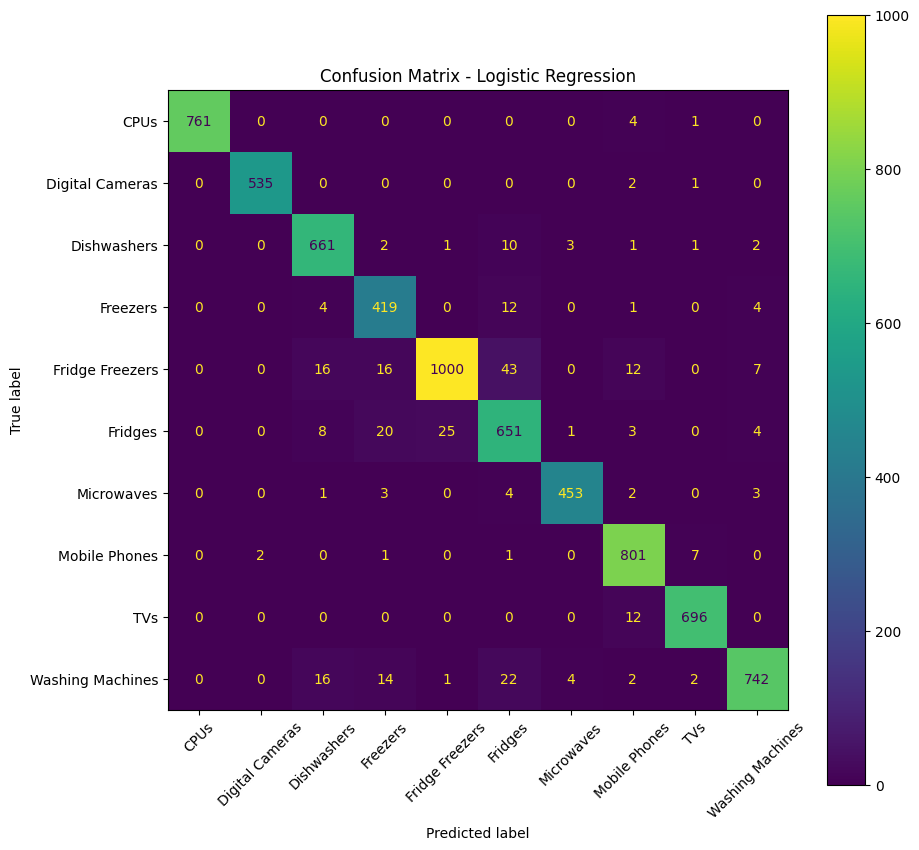

In [6]:
# Afisam confusion matrix pentru Logistic Regression
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_estimator(
    model_lr,
    X_test,
    y_test,
    xticks_rotation=45,
    ax=ax
)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [7]:
# Modelul 2: Linear Support Vector Classifier
from sklearn.svm import LinearSVC

model_svc = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )),
    ("clf", LinearSVC(
        class_weight="balanced",
        random_state=42
    ))
])

model_svc


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))),
                ('clf', LinearSVC(class_weight='balanced', random_state=42))])

In [8]:
# Antrenam modelul LinearSVC
model_svc.fit(X_train, y_train)

# Predictii pe setul de test
pred_svc = model_svc.predict(X_test)

# Evaluare
acc_svc = accuracy_score(y_test, pred_svc)

print("LinearSVC - Accuracy:", acc_svc)
print("\nClassification report:\n")
print(classification_report(y_test, pred_svc))


LinearSVC - Accuracy: 0.9655270655270656

Classification report:

                  precision    recall  f1-score   support

            CPUs       1.00      1.00      1.00       766
 Digital Cameras       1.00      0.99      1.00       538
     Dishwashers       0.94      0.97      0.95       681
        Freezers       0.90      0.96      0.93       440
 Fridge Freezers       0.96      0.95      0.96      1094
         Fridges       0.91      0.92      0.92       712
      Microwaves       0.98      0.97      0.98       466
   Mobile Phones       0.98      0.99      0.98       812
             TVs       0.98      0.99      0.98       708
Washing Machines       0.99      0.93      0.96       803

        accuracy                           0.97      7020
       macro avg       0.96      0.97      0.97      7020
    weighted avg       0.97      0.97      0.97      7020



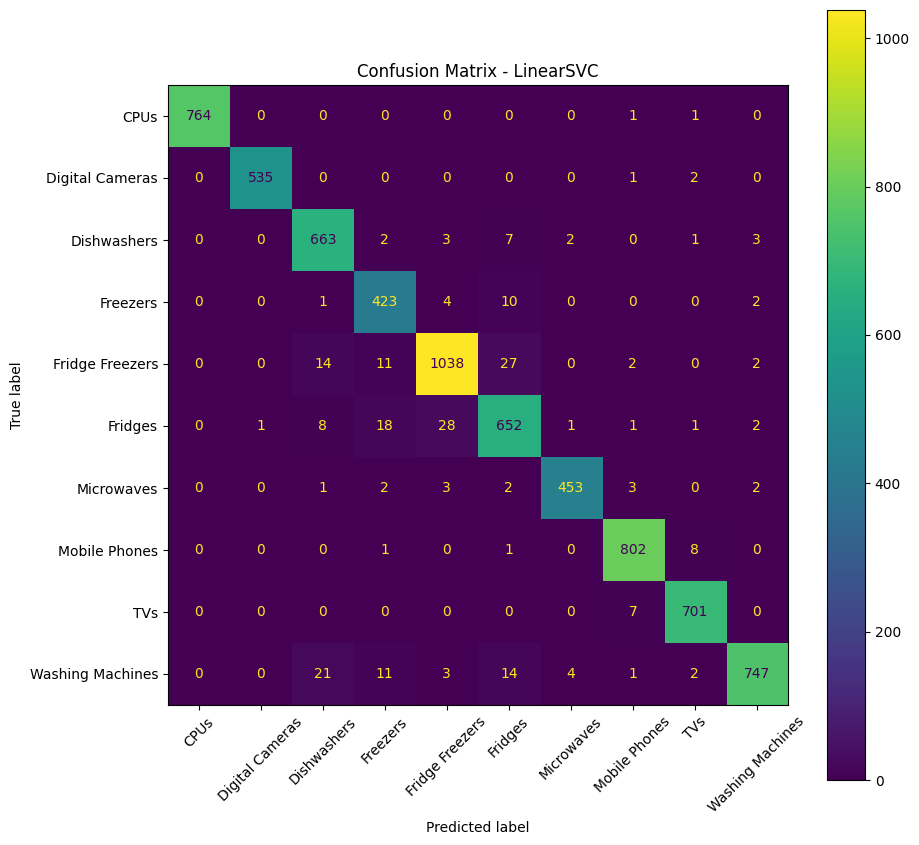

In [9]:
# Afisam confusion matrix pentru LinearSVC
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_estimator(
    model_svc,
    X_test,
    y_test,
    xticks_rotation=45,
    ax=ax
)
plt.title("Confusion Matrix - LinearSVC")
plt.show()


In [10]:
# Cream un mic tabel comparativ pentru modele
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "LinearSVC"],
    "Accuracy": [acc_lr, acc_svc]
})

comparison


,Model,Accuracy
0,Logistic Regression,0.957123
1,LinearSVC,0.965527


In [11]:
# Alegem modelul final pe baza performantei.
# Daca LinearSVC are scor mai bun sau similar, il alegem pe acesta.
# Altfel, ramanem la Logistic Regression.

if acc_svc >= acc_lr:
    final_model = model_svc
    final_model_name = "LinearSVC"
else:
    final_model = model_lr
    final_model_name = "Logistic Regression"

final_model_name


'LinearSVC'

In [12]:
# Testam modelul final cu exemplele din task.
tests = [
    "iphone 7 32gb gold,4,3,Apple iPhone 7 32GB",
    "olympus e m10 mark iii geh use silber",
    "kenwood k20mss15 solo",
    "bosch wap28390gb 8kg 1400 spin",
    "bosch serie 4 kgv39vl31g",
    "smeg sbs8004po"
]

for t in tests:
    print(t, "=>", final_model.predict([t.lower().strip()])[0])


iphone 7 32gb gold,4,3,Apple iPhone 7 32GB => Mobile Phones
olympus e m10 mark iii geh use silber => Digital Cameras
kenwood k20mss15 solo => Microwaves
bosch wap28390gb 8kg 1400 spin => Washing Machines
bosch serie 4 kgv39vl31g => Dishwashers
smeg sbs8004po => Fridges


In [13]:
# Salvam modelul final ales intr-un fisier .pkl
# Acesta este modelul care va fi folosit in productie si in scriptul predict_category.py
import joblib, os

os.makedirs("/content/models", exist_ok=True)

FINAL_MODEL_PATH = "/content/models/product_category_model.pkl"
joblib.dump(final_model, FINAL_MODEL_PATH)

FINAL_MODEL_PATH


'/content/models/product_category_model.pkl'